<div style="background-color: skyblue; padding: 10px;">
    
## Setup

First, import all neccessary packages and define all the variables.

In [1]:
import os
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


%matplotlib inline

In [2]:
#all variables
data_classified = 'Data/classified'
data_raw = 'Data/raw'
data_alpha = 'Data/diversity'
data_abundance ='Data/abundance'

The biggest differences were found between the sterile and non-sterile environment during beta diversity analysis, so these will be looked at. 

In [5]:
#First, we look at the distribution of our data. 
data = q2.Artifact.load(f'{data_raw}/modified-dada1-table-highschool.qza').view(pd.DataFrame)

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [6]:
data.shape

(548, 19899)

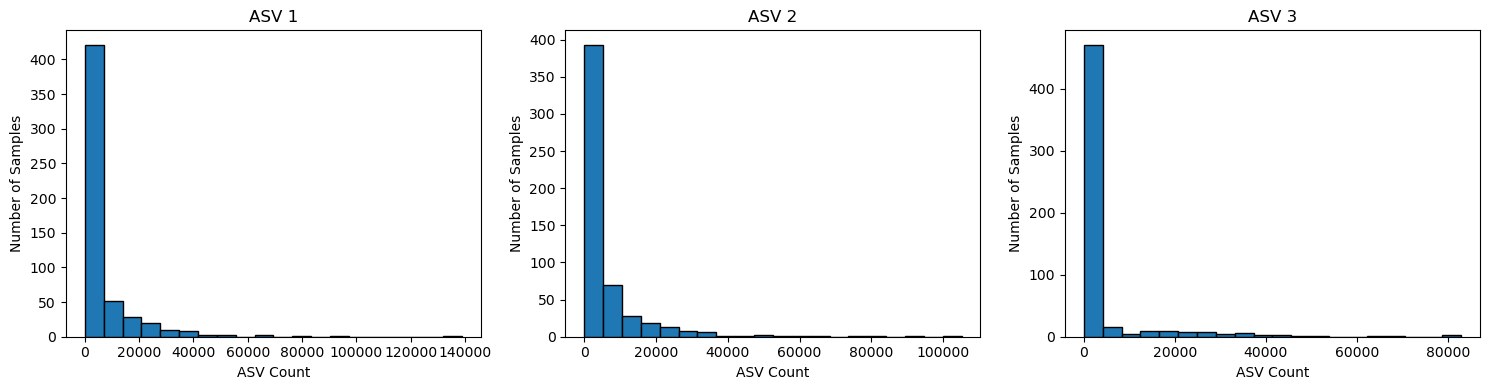


Top 3 ASV identifiers:
1. f228dd6b54c8587a0e366a57ab4d0904 (total: 3150979.0)
2. 23f8d77e0da2129f8b93b5ca894b5771 (total: 3065488.0)
3. c1f82285dd8e54d0759cc5b4589bd81e (total: 1907950.0)


In [7]:
data
# Get the top three most abundant sequence variants
# based on sum of observed sequence counts. Create a dataframe of ASV counts 
# with samples as rows and sequence variants as columns.
top_three = data[data.sum().nlargest(3).index]
# Your turn to try! Now view each of them as a histogram, as number of samples per ASV.
# View each as a histogram showing number of samples per ASV count value
import matplotlib.pyplot as plt

top_asv_names = top_three.columns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))


for i, asv in enumerate(top_asv_names):
    axes[i].hist(top_three[asv], bins=20, edgecolor='black')
    axes[i].set_xlabel('ASV Count')
    axes[i].set_ylabel('Number of Samples')
    axes[i].set_title(f'ASV {i+1}')

plt.tight_layout()
plt.show()

# Print the actual ASV identifiers
print("\nTop 3 ASV identifiers:")
for i, asv in enumerate(top_asv_names, 1):
    print(f"{i}. {asv} (total: {data[asv].sum()})")

<div style="background-color: skyblue; padding: 10px;">

## Filtering and ANCOM BC for sterile vs non-sterile evironment

Based on the shape of the data and the distribution of above, the following parameters for
filtering were chosen:

In [16]:

! qiime feature-table filter-features \
  --i-table $data_classified/table-filtered.qza \
  --p-min-frequency 50 \
  --p-min-samples 10 \
  --o-filtered-table $data_abundance/table_abund.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund.qza


In [7]:
#Check if there are any other values than sterile and non-sterile in the merged metadata in the background column
md_merged = pd.read_csv(f'{data_raw}/merged_output_usable.tsv', sep='\t')
md_merged['background'].unique()

array(['non-sterile', 'sterile', nan], dtype=object)

We want to look at differences betwen non-sterile and sterile environment since nan values are in df, filter for sterile and non-sterile values.

In [8]:

! qiime feature-table filter-samples \
    --i-table $data_abundance/table_abund.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-where "[background]='sterile' OR [background]='non-sterile'" \
    --o-filtered-table $data_abundance/table_abund_sterile_nonsterile.qza

#make it into a visualization
! qiime feature-table summarize \
    --i-table $data_abundance/table_abund_sterile_nonsterile.qza \
    --m-sample-metadata-file $data_raw/merged_output_usable.tsv \
    --o-visualization $data_abundance/table_abund_sterile_nonsterile.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile.qza
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/table_abund_sterile_nonsterile.qzv


In [21]:

# Run ANCOM-BC to test which ASVs differ between sterile and non-sterile
#first we start with an overall background comparison
! qiime composition ancombc \
    --i-table $data_abundance/table_abund_sterile_nonsterile.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-formula background \
    --o-differentials $data_abundance/ancombc_sterile_nonsterile_differentials.qza

# Generate a barplot of differentially abundant taxa between sterile and non-sterile backgrounds
! qiime composition da-barplot \
    --i-data $data_abundance/ancombc_sterile_nonsterile_differentials.qza \
    --o-visualization $data_abundance/ancombc_sterile_nonsterile_da_barplot.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_differentials.qza


In [3]:

Visualization.load(f"{data_abundance}/ancombc_sterile_nonsterile_da_barplot.qzv")

<visualization: Visualization uuid: 7ed5166e-a4a4-4533-8e97-e08219b98ac5>

A difference between sterile and non-sterile environment could be observed. In the next step, 
in the next step it will be observed how these 

<div style="background-color: skyblue; padding: 10px;">

## ANCOM BC to see differences on species between sterile and non-sterile over time

Now we did a general analysis, and saw there were definetly some samples
enriched vs. depleted in the analysis. Now we want to try and answer the 
following questions by differential abundance: 
2. How did the fungal communities change over time between sterile vs.
non-sterile starter backgrounds? Is one background more ‘resilient’ towards
invading fungi directly coming from participants' hands?
3. Which taxa consistently transfer from hand to dough — and which resist
colonization?

We try to answer this question first:  2. How did the fungal communities change over time between sterile vs.
non-sterile starter backgrounds? Is one background more ‘resilient’ towards
invading fungi directly coming from participants' hands?
For this, we want to run a ANCOM bc test between sterile vs non-sterile background
at the different time points (we have the time points 0, 7, 14 and 21)

In [33]:
#Some data in the day column are empty, so first we need to filter the metadata df for only 
#data where there is a time point
md_time = pd.read_csv(f'{data_raw}/merged_output_usable.tsv', sep='\t')
# Drop rows where 'day' column is missing/empty
md_time = md_time[md_time['day'].notna()].copy()
# Save to new file
md_time.to_csv(f'{data_raw}/md_time.tsv', sep='\t', index=False)

For loop through each time point, to run ANCOM BC test at each time point for sterile 
and non-sterile environment. 

In [35]:


# Different time points 
days = [0, 7, 14, 21]

# Loop through each day
for day in days:
    print(f"Processing day {day}...")
    
    # Filter for current day samples
    os.system(f"""qiime feature-table filter-samples \
        --i-table {data_abundance}/table_abund_sterile_nonsterile.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-where "[day]='{day}'" \
        --o-filtered-table {data_abundance}/table_abund_sterile_nonsterile_day{day}.qza""")
    
    # Run ANCOM-BC on current day
    os.system(f"""qiime composition ancombc \
        --i-table {data_abundance}/table_abund_sterile_nonsterile_day{day}.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-formula background \
        --o-differentials {data_abundance}/ancombc_sterile_nonsterile_day{day}_differentials.qza""")
    
    print(f"Completed day {day}\n")

print("All days processed!")

Processing day 0...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day0.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day0_differentials.qza
Completed day 0

Processing day 7...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day7.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day7_differentials.qza
Completed day 7

Processing day 14...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day14.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day14_differentials.qza
Completed day 14

Processing day 21...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day21.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day21_differentials.qza
Completed day 21

All days processed!


In [ ]:
#Export the results of each time point
import os

# Export each time point's results
days = [0, 7, 14, 21]
for day in days:
    os.system(f"""
        qiime tools export \
            --input-path {data_abundance}/ancombc_sterile_nonsterile_day{day}_differentials.qza \
            --output-path {data_abundance}/exported_day{day}
    """)

In [9]:

days = [0, 7, 14, 21] 

# Load the differential abundance results for each time point 
results = {} 

for day in days: 
    # Read all the slice files
    lfc = pd.read_csv(f"{data_abundance}/exported_day{day}/lfc_slice.csv", index_col=0)
    p_val = pd.read_csv(f"{data_abundance}/exported_day{day}/p_val_slice.csv", index_col=0) 
    q_val = pd.read_csv(f"{data_abundance}/exported_day{day}/q_val_slice.csv", index_col=0) 
    se = pd.read_csv(f"{data_abundance}/exported_day{day}/se_slice.csv", index_col=0)
    w = pd.read_csv(f"{data_abundance}/exported_day{day}/w_slice.csv", index_col=0) 
    
    # Combine into one dataframe
    df = pd.DataFrame({
        'lfc': lfc.iloc[:, 0], 
        'p_val': p_val.iloc[:, 0], 
        'q_val': q_val.iloc[:, 0], 
        'se': se.iloc[:, 0], 
        'w': w.iloc[:, 0]
    }) 
    
    df.index.name = 'id'
    df = df.reset_index()
    results[day] = df

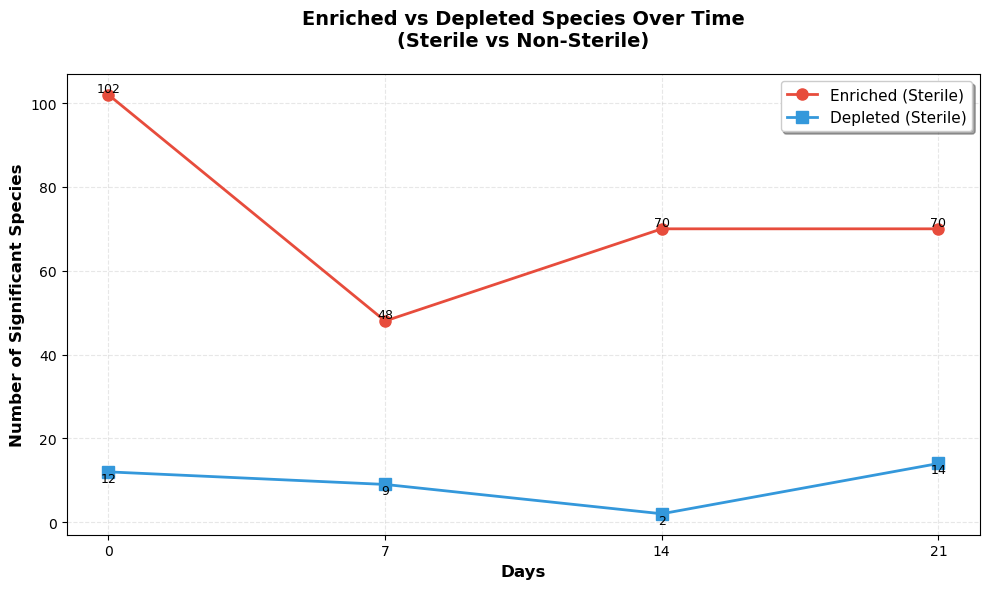

In [11]:
# Count enriched and depleted species at each time point
# Using q-value < 0.05 for significance and lfc for direction
enriched_counts = []
depleted_counts = []
significance_threshold = 0.05

for day in days:
    df = results[day]
    
    # Significant enriched (lfc > 0, q_val < 0.05)
    enriched = df[(df['lfc'] > 0) & (df['q_val'] < significance_threshold)].shape[0]
    
    # Significant depleted (lfc < 0, q_val < 0.05)
    depleted = df[(df['lfc'] < 0) & (df['q_val'] < significance_threshold)].shape[0]
    
    enriched_counts.append(enriched)
    depleted_counts.append(depleted)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(days, enriched_counts, marker='o', linewidth=2, markersize=8, 
        label='Enriched (Sterile)', color='#e74c3c')
ax.plot(days, depleted_counts, marker='s', linewidth=2, markersize=8, 
        label='Depleted (Sterile)', color='#3498db')

ax.set_xlabel('Days', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Significant Species', fontsize=12, fontweight='bold')
ax.set_title('Enriched vs Depleted Species Over Time\n(Sterile vs Non-Sterile)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks(days)

# Add value labels on points
for i, day in enumerate(days):
    ax.text(day, enriched_counts[i], str(enriched_counts[i]), 
            ha='center', va='bottom', fontsize=9)
    ax.text(day, depleted_counts[i], str(depleted_counts[i]), 
            ha='center', va='top', fontsize=9)

plt.tight_layout()
plt.show()



<div style="background-color: skyblue; padding: 10px;">

## Analysis on the species level

Now, let's do the same with species identification. For this we need to collapse the 
table on species level. 

In [34]:

! qiime taxa collapse \
    --i-table $data_abundance/table_abund.qza \
    --i-taxonomy $data_classified/taxonomy.qza \
    --p-level 7 \
    --o-collapsed-table $data_abundance/table_abund_l7.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund_l7.qza


Run ANCOM BC on species level for all the different time points.

In [ ]:
import os

# Define the days to process
days = [0, 7, 14, 21]

# Loop through each day
for day in days:
    print(f"Processing day {day}...")
    
    # Filter for current day samples
    status1 = os.system(f"""qiime feature-table filter-samples \
        --i-table {data_abundance}/table_abund_l7.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-where "[day]='{day}'" \
        --o-filtered-table {data_abundance}/table_abund_sterile_nonsterile_l7_day{day}.qza""")
    
    if status1 != 0:
        print(f"Error filtering day {day}")
        continue
    
    # Run ANCOM-BC on current day
    status2 = os.system(f"""qiime composition ancombc \
        --i-table {data_abundance}/table_abund_sterile_nonsterile_l7_day{day}.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-formula background \
        --o-differentials {data_abundance}/ancombc_sterile_nonsterile_l7_day{day}_differentials.qza""")
    
    if status2 != 0:
        print(f"Error running ANCOM-BC for day {day}")
    else:
        print(f"✓ Completed day {day}\n")

print("All days processed!")

Processing day 0...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_l7_day0.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_l7_day0_differentials.qza
✓ Completed day 0

Processing day 7...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_l7_day7.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources

Aborted!


Error running ANCOM-BC for day 7
Processing day 14...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_l7_day14.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [16]:


# Export each time point's results
days = [0, 7, 14, 21]

for day in days:
    print(f"Exporting day {day} results...")
    
    status = os.system(f"""qiime tools export \
        --input-path {data_abundance}/ancombc_sterile_nonsterile_l7_day{day}_differentials.qza \
        --output-path {data_abundance}/exported_l7_day{day}""")
    
    if status != 0:
        print(f"Error exporting day {day}")
    else:
        print(f"✓ Exported day {day}\n")

print("All exports completed!")

Exporting day 0 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_l7_day0_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_day0
✓ Exported day 0

Exporting day 7 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_l7_day7_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_day7
✓ Exported day 7

Exporting day 14 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_l7_day14_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_day14
✓ Exported day 14

Exporting day 21 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_l7_day21_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_day21
✓ Exported day 21

All exports completed!


In [13]:
# Load the differential species abundance results for each time point
days = [0, 7, 14, 21]
results_species_level = {}

for day in days:
    lfc = pd.read_csv(f"{data_abundance}/exported_l7_day{day}/lfc_slice.csv", index_col=0)
    p_val = pd.read_csv(f"{data_abundance}/exported_l7_day{day}/p_val_slice.csv", index_col=0)
    q_val = pd.read_csv(f"{data_abundance}/exported_l7_day{day}/q_val_slice.csv", index_col=0)
    se = pd.read_csv(f"{data_abundance}/exported_l7_day{day}/se_slice.csv", index_col=0)
    w = pd.read_csv(f"{data_abundance}/exported_l7_day{day}/w_slice.csv", index_col=0)
    
    df = pd.DataFrame({
        'lfc': lfc.iloc[:, 0],
        'p_val': p_val.iloc[:, 0],
        'q_val': q_val.iloc[:, 0],
        'se': se.iloc[:, 0],
        'w': w.iloc[:, 0]
    })
    df.index.name = 'id'
    df = df.reset_index()
    results_species_level[day] = df


Total taxa with significant directional changes: 18
  • Depleted in Sterile (negative slope): 11
  • Enriched in Sterile (positive slope): 7


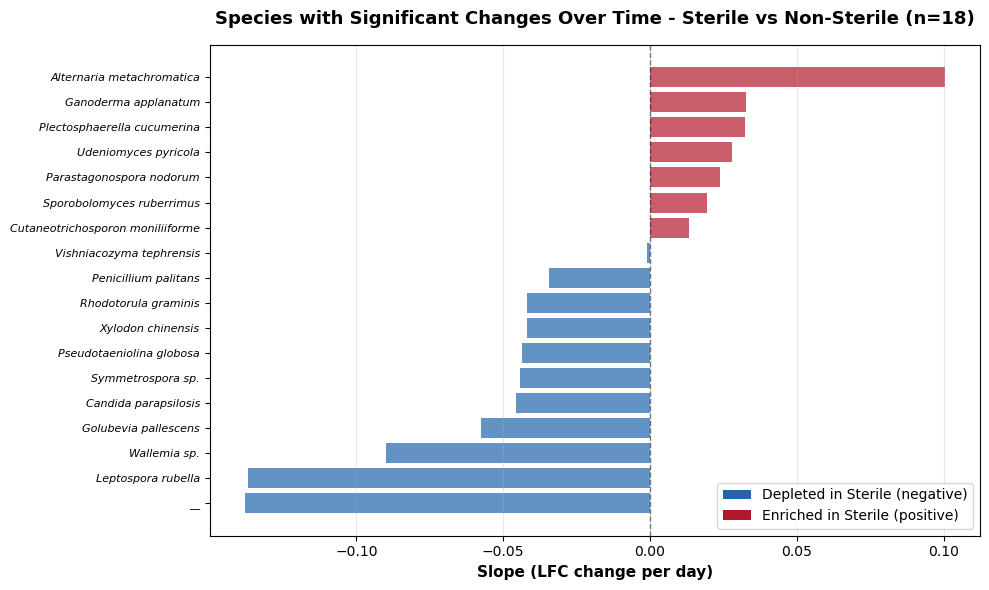

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.patches import Patch

# === DATA PREPARATION ===
combined = pd.concat([
    df[df['q_val'] < 0.05].assign(day=day) 
    for day, df in results_species_level.items()
])

species_counts = combined['id'].value_counts()
multi_timepoint = combined[combined['id'].isin(
    species_counts[species_counts >= 2].index
)]

# === REGRESSION ANALYSIS ===
regression_results = []
for species, data in multi_timepoint.groupby('id'):
    slope, intercept, r_value, p_value, _ = stats.linregress(data['day'], data['lfc'])
    regression_results.append({
        'species': species,
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2,
        'p_value': p_value
    })

regression_df = pd.DataFrame(regression_results).sort_values('slope')
regression_df['pattern'] = regression_df.apply(
    lambda r: 'Depleted in Sterile' if r['p_value'] < 0.05 and r['slope'] < 0 
    else 'Enriched in Sterile' if r['p_value'] < 0.05 and r['slope'] > 0 
    else 'No change', axis=1
)

# Keep only taxa with significant directional changes
filtered_df = regression_df[regression_df['pattern'] != 'No change'].copy()

# === SPECIES NAME EXTRACTION ===
def extract_species_name(taxonomy):
    parts = taxonomy.split(';')
    genus = ''
    species = ''
    family = ''
    
    for part in parts:
        part = part.strip()
        if part.startswith('g__'):
            genus = part.replace('g__', '').strip()
        elif part.startswith('s__'):
            species_full = part.replace('s__', '').strip()
            if '_' in species_full:
                species = species_full.split('_')[1]
        elif part.startswith('f__'):
            family = part.replace('f__', '').strip()
    
    if genus and species:
        return f"{genus} {species}"
    elif genus:
        return f"{genus} sp."
    elif family:
        return family
    return parts[-1].strip()

filtered_df['species_name'] = filtered_df['species'].apply(extract_species_name)

# Remove taxa that couldn't be classified (just underscores or empty)
filtered_df = filtered_df[~filtered_df['species_name'].str.strip().isin(['', '_'])].copy()

print(f"\nTotal taxa with significant directional changes: {len(filtered_df)}")
print(f"  • Depleted in Sterile (negative slope): {(filtered_df['pattern'] == 'Depleted in Sterile').sum()}")
print(f"  • Enriched in Sterile (positive slope): {(filtered_df['pattern'] == 'Enriched in Sterile').sum()}")

# === BAR CHART - ALL TAXA ===
fig, ax = plt.subplots(figsize=(10, max(6, len(filtered_df) * 0.3)))

colors = ['#2166ac' if p == 'Depleted in Sterile' else '#b2182b' for p in filtered_df['pattern']]
y_pos = np.arange(len(filtered_df))

ax.barh(y_pos, filtered_df['slope'], color=colors, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(filtered_df['species_name'], style='italic', fontsize=8)
ax.set_xlabel('Slope (LFC change per day)', fontsize=11, fontweight='bold')
ax.set_title(f'Species with Significant Changes Over Time - Sterile vs Non-Sterile (n={len(filtered_df)})', 
             fontsize=13, fontweight='bold', pad=15)
ax.axvline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
ax.grid(axis='x', alpha=0.3)

ax.legend([Patch(facecolor='#2166ac'), Patch(facecolor='#b2182b')], 
          ['Depleted in Sterile (negative)', 'Enriched in Sterile (positive)'], 
          loc='lower right')

plt.tight_layout()
plt.show()

<div style="background-color: skyblue; padding: 10px;">

## ANCOM BC analysis for hand and sourdough over time

First, check if there are differences between hand and sourdough.

In [8]:

#check for unique values in the sample_type column
md_merged['sample_type'].unique()

array(['sourdough', 'control_n', 'control_pcr', 'control_p', 'empty',
       'hand_swabs'], dtype=object)

In [25]:

#Filter for hand_swabs and sourdough samples
! qiime feature-table filter-samples \
    --i-table $data_abundance/table_abund.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-where "[sample_type]='hand_swabs' OR [sample_type]='sourdough'" \
    --o-filtered-table $data_abundance/table_hand_dough.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_hand_dough.qza


In [4]:
! qiime composition ancombc \
    --i-table $data_abundance/table_hand_dough.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-formula "sample_type" \
    --p-reference-levels "sample_type::hand_swabs" \
    --o-differentials $data_abundance/table_hand_dough_person_filtered.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: Data/abundance/table_hand_dough_person_filtered.qza


In [15]:
! qiime tools export \
    --input-path $data_abundance/table_hand_dough_person_filtered.qza \
    --output-path $data_abundance/exported_hand_vs_dough

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Exported Data/abundance/table_hand_dough_person_filtered.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_hand_vs_dough


In [5]:
#turn into visualization 
! qiime composition tabulate \
    --i-data $data_abundance/table_hand_dough_person_filtered.qza \
    --o-visualization $data_abundance/table_hand_dough_person_filtered.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/table_hand_dough_person_filtered.qzv


In [7]:
#Visualize
! qiime composition da-barplot \
    --i-data $data_abundance/table_hand_dough_person_filtered.qza \
    --o-visualization $data_abundance/ancombc_hand_dough_barplot.qzv


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/ancombc_hand_dough_barplot.qzv


In [9]:
Visualization.load(f"Data/abundance/table_hand_dough_person_filtered.qzv")

<visualization: Visualization uuid: 6073e2d3-2d82-4e38-9076-f4bc7078c503>

In [15]:
Visualization.load(f"Data/abundance/ancombc_hand_dough_barplot.qzv")

<visualization: Visualization uuid: 7f0b92d8-1602-4920-bf40-9cbaf8377179>

<div style="background-color: skyblue; padding: 10px;">

## ANCOM BC analysis for sourdough vs hand over time in sterile and non-sterile background

We saw that there is a difference between hand and sourdough taxa. Now we want to compare the hand and sourdough taxa over time in the sterile vs non-sterile environment. For this we once do the ANCOM BC test for the sterile environment and once for the non-sterile environment. 

### Sterile environment

In [11]:
#Looping through the different time points again for sourdough vs. hand_swabs for 
#the sterile environment
#Hand_swabs will be used as reference by qime-2, because of alphabetical order

# Define the days to process
days = [0, 7, 14, 21]

# Loop through each day
for day in days:
    print(f"Processing day {day}...")
    
    # Filter for current day samples (hand_swabs and sourdough only, sterile background)
    status1 = os.system(f"""qiime feature-table filter-samples \
        --i-table {data_abundance}/table_abund_l7.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-where "[day]='{day}' AND ([sample_type]='hand_swabs' OR [sample_type]='sourdough') AND [background]='sterile'" \
        --o-filtered-table {data_abundance}/table_abund_hand_vs_sourdough_l7_day{day}.qza""")
    
    if status1 != 0:
        print(f"Error filtering day {day}")
        continue
    
    # Run ANCOM-BC on current day (comparing sample_type instead of background)
    status2 = os.system(f"""qiime composition ancombc \
        --i-table {data_abundance}/table_abund_hand_vs_sourdough_l7_day{day}.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-formula sample_type \
        --o-differentials {data_abundance}/ancombc_l7_sterile_day{day}_differentials.qza""")
    
    if status2 != 0:
        print(f"Error running ANCOM-BC for day {day}")
    else:
        print(f"✓ Completed day {day}\n")

print("All days processed!")

Processing day 0...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day0.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Plugin error from composition:

  An error was encountered while running ANCOM-BC in R (return code 1), please inspect stdout and stderr to learn more.

Debug info has been saved to /tmp/qiime2-q2cli-err-fhj4ju_t.log


Error running ANCOM-BC for day 0
Processing day 7...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day7.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_l7_sterile_day7_differentials.qza
✓ Completed day 7

Processing day 14...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day14.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_l7_sterile_day14_differentials.qza
✓ Completed day 14

Processing day 21...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day21.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_l7_sterile_day21_differentials.qza
✓ Completed day 21

All days processed!



There is no data for the sourdoughs from day 0, so day 0 will be excluded from the analysis. 

In [13]:
# Export each time point's results for sterile environment
days = [7, 14, 21]
for day in days:
    print(f"Exporting day {day} results...")
    
    status = os.system(f"""qiime tools export \
        --input-path {data_abundance}/ancombc_l7_sterile_day{day}_differentials.qza \
        --output-path {data_abundance}/exported_l7_sterile_day{day}""")
    
    if status != 0:
        print(f"Error exporting day {day}")
    else:
        print(f"✓ Exported day {day}\n")
print("All exports completed!")

Exporting day 7 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_l7_sterile_day7_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_sterile_day7
✓ Exported day 7

Exporting day 14 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_l7_sterile_day14_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_sterile_day14
✓ Exported day 14

Exporting day 21 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_l7_sterile_day21_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_sterile_day21
✓ Exported day 21

All exports completed!


In [3]:
#Load the results into pandas
results_species_level_sterile = {}
days = [7, 14, 21]
for day in days:
    lfc = pd.read_csv(f"{data_abundance}/exported_l7_sterile_day{day}/lfc_slice.csv", index_col=0)
    p_val = pd.read_csv(f"{data_abundance}/exported_l7_sterile_day{day}/p_val_slice.csv", index_col=0)
    q_val = pd.read_csv(f"{data_abundance}/exported_l7_sterile_day{day}/q_val_slice.csv", index_col=0)
    se = pd.read_csv(f"{data_abundance}/exported_l7_sterile_day{day}/se_slice.csv", index_col=0)
    w = pd.read_csv(f"{data_abundance}/exported_l7_sterile_day{day}/w_slice.csv", index_col=0)
    
    df = pd.DataFrame({
        'lfc': lfc.iloc[:, 0],
        'p_val': p_val.iloc[:, 0],
        'q_val': q_val.iloc[:, 0],
        'se': se.iloc[:, 0],
        'w': w.iloc[:, 0]
    })
    df.index.name = 'id'
    df = df.reset_index()
    results_species_level_sterile[day] = df



Total taxa with significant directional changes: 27
  • Transfer (negative slope): 10
  • Depletion (positive slope): 17


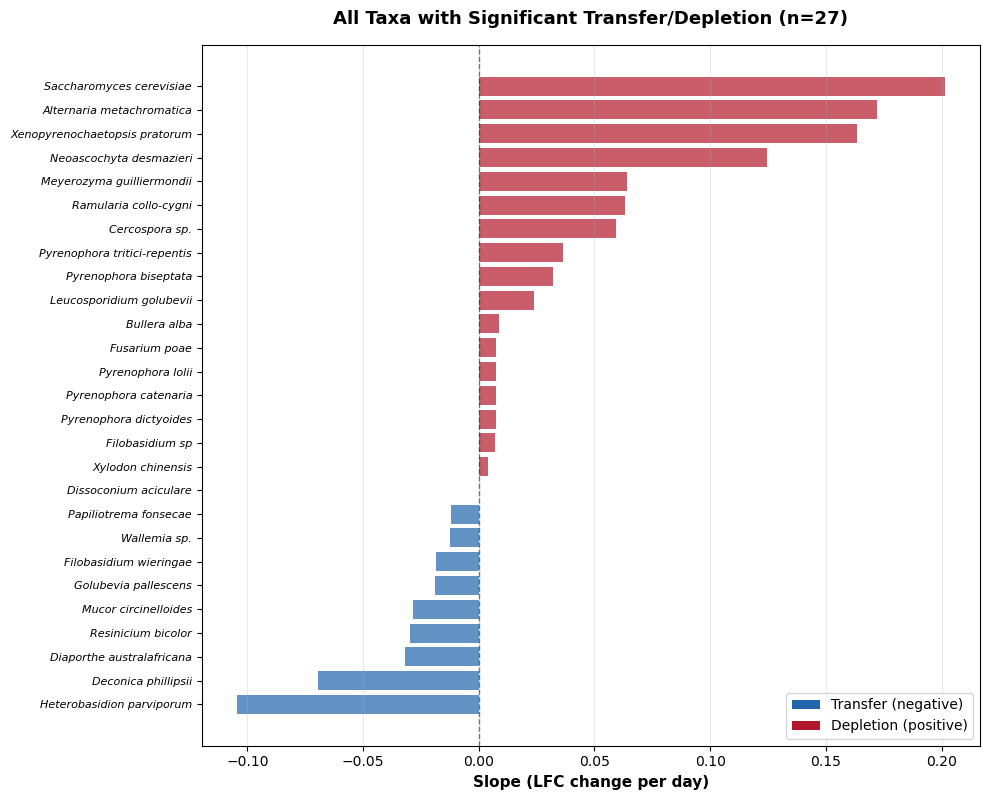

In [7]:

# === DATA PREPARATION ===
combined_sterile = pd.concat([
    df[df['q_val'] < 0.05].assign(day=day) 
    for day, df in results_species_level_sterile.items()
])

species_counts = combined_sterile['id'].value_counts()
multi_timepoint = combined_sterile[combined_sterile['id'].isin(
    species_counts[species_counts >= 2].index
)]

# === REGRESSION ANALYSIS ===
regression_results = []
for species, data in multi_timepoint.groupby('id'):
    slope, intercept, r_value, p_value, _ = stats.linregress(data['day'], data['lfc'])
    regression_results.append({
        'species': species,
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2,
        'p_value': p_value
    })

regression_df = pd.DataFrame(regression_results).sort_values('slope')
regression_df['pattern'] = regression_df.apply(
    lambda r: 'Transfer' if r['p_value'] < 0.05 and r['slope'] < 0 
    else 'Depletion' if r['p_value'] < 0.05 and r['slope'] > 0 
    else 'No change', axis=1
)

# Keep only taxa with significant directional changes
filtered_df = regression_df[regression_df['pattern'] != 'No change'].copy()

def extract_species_name(taxonomy):
    parts = taxonomy.split(';')
    genus = ''
    species = ''
    family = ''
    
    for part in parts:
        part = part.strip()
        if part.startswith('g__'):
            genus = part.replace('g__', '').strip()
        elif part.startswith('s__'):
            species_full = part.replace('s__', '').strip()
            if '_' in species_full:
                species = species_full.split('_')[1]
        elif part.startswith('f__'):
            family = part.replace('f__', '').strip()
    
    if genus and species:
        return f"{genus} {species}"
    elif genus:
        return f"{genus} sp."
    elif family:
        return family
    return parts[-1].strip()

filtered_df['species_name'] = filtered_df['species'].apply(extract_species_name)

print(f"\nTotal taxa with significant directional changes: {len(filtered_df)}")
print(f"  • Transfer (negative slope): {(filtered_df['pattern'] == 'Transfer').sum()}")
print(f"  • Depletion (positive slope): {(filtered_df['pattern'] == 'Depletion').sum()}")

# === BAR CHART - ALL TAXA ===
fig, ax = plt.subplots(figsize=(10, len(filtered_df) * 0.3))

colors = ['#2166ac' if p == 'Transfer' else '#b2182b' for p in filtered_df['pattern']]
y_pos = np.arange(len(filtered_df))

ax.barh(y_pos, filtered_df['slope'], color=colors, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(filtered_df['species_name'], style='italic', fontsize=8)
ax.set_xlabel('Slope (LFC change per day)', fontsize=11, fontweight='bold')
ax.set_title(f'All Taxa with Significant Transfer/Depletion (n={len(filtered_df)})', 
             fontsize=13, fontweight='bold', pad=15)
ax.axvline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
ax.grid(axis='x', alpha=0.3)

from matplotlib.patches import Patch
ax.legend([Patch(facecolor='#2166ac'), Patch(facecolor='#b2182b')], 
          ['Transfer (negative)', 'Depletion (positive)'], loc='lower right')
plt.tight_layout()
plt.show()


27 species with significant directional changes:
  Transfer: 10
  Depletion: 17


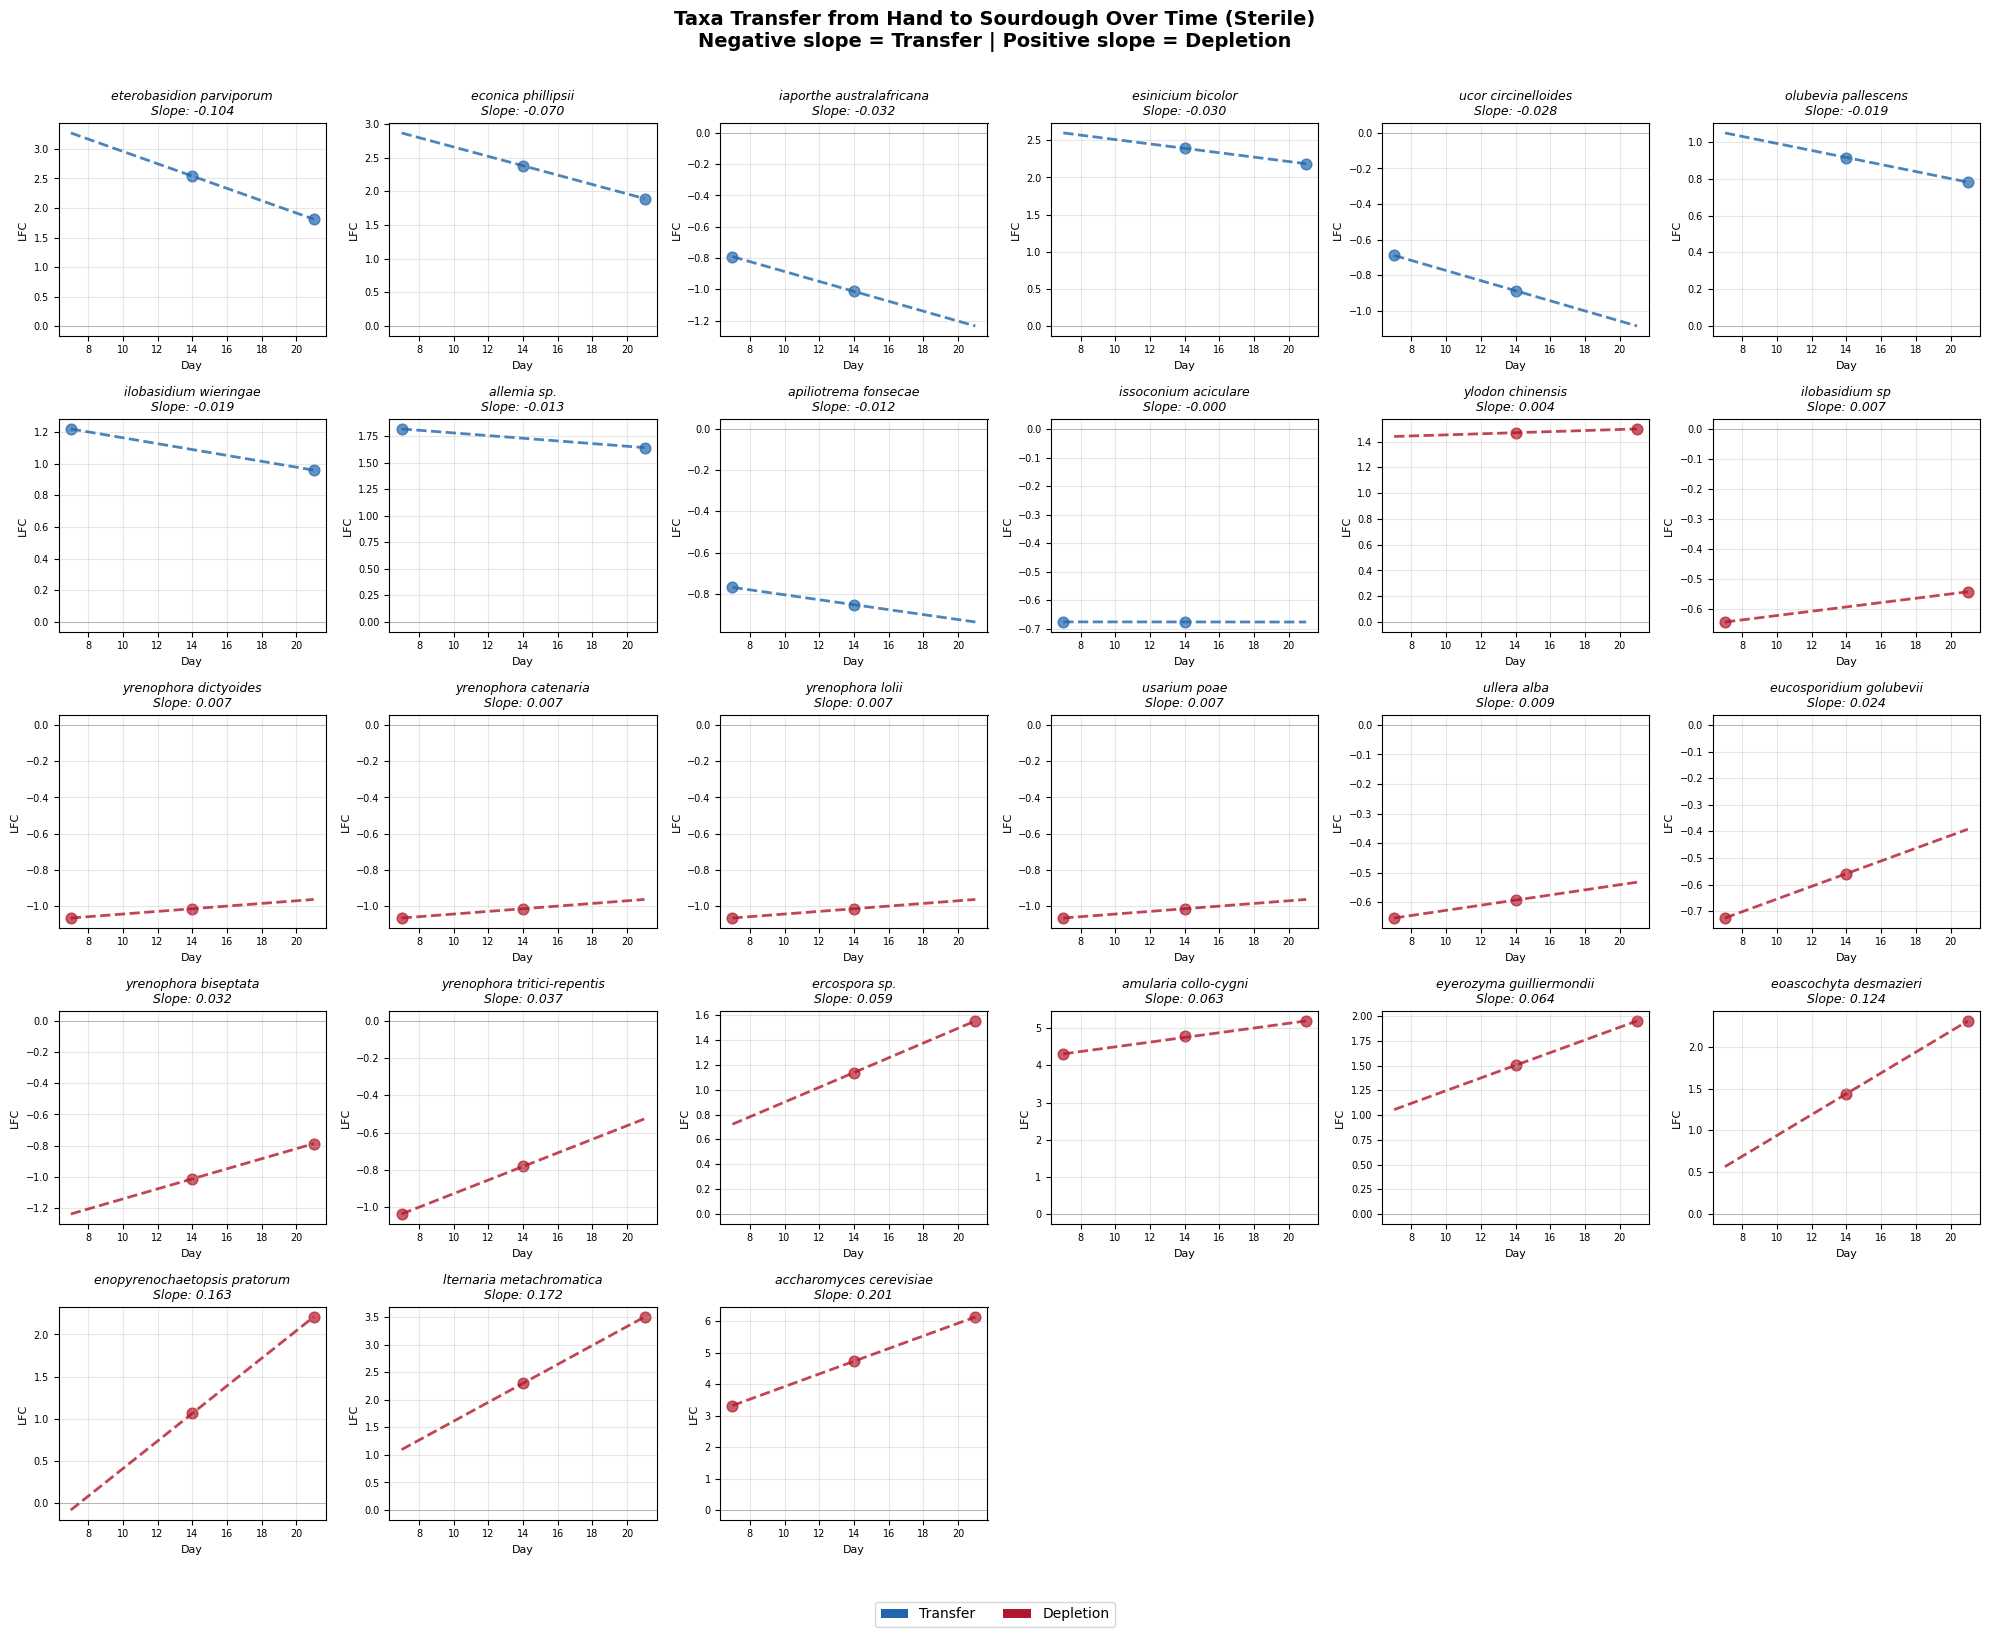


=== PATTERN SUMMARY ===
pattern
No change    50
Depletion    17
Transfer     10
Name: count, dtype: int64

=== TOP TRANSFERS (Most negative slopes) ===
                                              species     slope  r_squared  \
51  k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_... -0.104366        1.0   
44  k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_... -0.069629        1.0   
39  k__Fungi;p__Ascomycota;c__Sordariomycetes;o__D... -0.031703        1.0   
46  k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_... -0.029641        1.0   
76  k__Fungi;p__Mucoromycota;c__Mucoromycetes;o__M... -0.028364        1.0   
56  k__Fungi;p__Basidiomycota;c__Exobasidiomycetes... -0.019085        1.0   
67  k__Fungi;p__Basidiomycota;c__Tremellomycetes;o... -0.018603        1.0   
74  k__Fungi;p__Basidiomycota;c__Wallemiomycetes;o... -0.012549        1.0   
73  k__Fungi;p__Basidiomycota;c__Tremellomycetes;o... -0.012001        1.0   
5   k__Fungi;p__Ascomycota;c__Dothideomycetes;o__M... -0.000034    

In [4]:


# === DATA PREPARATION ===
# Combine all days and filter significant species
combined_sterile = pd.concat([
    df[df['q_val'] < 0.05].assign(day=day) 
    for day, df in results_species_level_sterile.items()
])

# Keep only species at 2+ timepoints
species_counts = combined_sterile['id'].value_counts()
multi_timepoint = combined_sterile[combined_sterile['id'].isin(
    species_counts[species_counts >= 2].index
)]

# === REGRESSION ANALYSIS ===
regression_results = []
for species, data in multi_timepoint.groupby('id'):
    slope, intercept, r_value, p_value, _ = stats.linregress(data['day'], data['lfc'])
    regression_results.append({
        'species': species,
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2,
        'p_value': p_value
    })

regression_df = pd.DataFrame(regression_results).sort_values('slope')

# Classify patterns (only keep significant directional changes)
regression_df['pattern'] = regression_df.apply(
    lambda r: 'Transfer' if r['p_value'] < 0.05 and r['slope'] < 0 
    else 'Depletion' if r['p_value'] < 0.05 and r['slope'] > 0 
    else 'No change', axis=1
)

filtered_df = regression_df[regression_df['pattern'] != 'No change']

print(f"\n{len(filtered_df)} species with significant directional changes:")
print(f"  Transfer: {(filtered_df['pattern'] == 'Transfer').sum()}")
print(f"  Depletion: {(filtered_df['pattern'] == 'Depletion').sum()}")

# === VISUALIZATION ===
def extract_species_name(taxonomy):
    """Extract readable species name from taxonomy string"""
    parts = {p[:3]: p[4:] for p in taxonomy.split(';') if '__' in p}
    genus = parts.get('g__', '').strip()
    species = parts.get('s__', '').split('_')[1] if 's__' in parts else ''
    
    if genus and species:
        return f"{genus} {species}"
    return genus + " sp." if genus else parts.get('f__', taxonomy.split(';')[-1])

# Setup plot
n_species = min(len(filtered_df), 30)
n_cols = 6
n_rows = int(np.ceil(n_species / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3.2))
axes = np.atleast_2d(axes).flatten()

colors = {'Transfer': '#2166ac', 'Depletion': '#b2182b'}

# Plot each species
for idx, (_, reg) in enumerate(filtered_df.head(30).iterrows()):
    ax = axes[idx]
    data = combined_sterile[combined_sterile['id'] == reg['species']].sort_values('day')
    
    # Points and regression line
    ax.scatter(data['day'], data['lfc'], color=colors[reg['pattern']], s=60, alpha=0.7)
    x_line = np.array([7, 14, 21])
    ax.plot(x_line, reg['slope'] * x_line + reg['intercept'], '--', 
            color=colors[reg['pattern']], linewidth=2, alpha=0.8)
    ax.axhline(0, color='black', linewidth=0.5, alpha=0.3)
    
    # Formatting
    ax.set_title(f'{extract_species_name(reg["species"])}\nSlope: {reg["slope"]:.3f}', 
                 fontsize=9, fontstyle='italic')
    ax.set_xlabel('Day', fontsize=8)
    ax.set_ylabel('LFC', fontsize=8)
    ax.tick_params(labelsize=7)
    ax.grid(True, alpha=0.3)

# Clean up
for ax in axes[n_species:]:
    fig.delaxes(ax)

# Legend and title
from matplotlib.patches import Patch
fig.legend([Patch(facecolor=colors[p]) for p in colors], colors.keys(),
           loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02), fontsize=10)
plt.suptitle('Taxa Transfer from Hand to Sourdough Over Time (Sterile)\n' +
             'Negative slope = Transfer | Positive slope = Depletion',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0.02, 1, 0.99])
plt.show()

# === SUMMARY ===
print("\n=== PATTERN SUMMARY ===")
print(regression_df['pattern'].value_counts())
print("\n=== TOP TRANSFERS (Most negative slopes) ===")
print(regression_df[regression_df['pattern'] == 'Transfer'].head(10)[
    ['species', 'slope', 'r_squared', 'p_value']
])
print("\n=== TOP DEPLETIONS (Most positive slopes) ===")
print(regression_df[regression_df['pattern'] == 'Depletion'].head(10)[
    ['species', 'slope', 'r_squared', 'p_value']
])

### Non-sterile environment

In [ ]:
#And once for the non-sterile environment
# Define the days to process
#Hand_swabs will be used as reference by qime-2, because of alphabetical order
days = [7, 14, 21]

# Loop through each day
for day in days:
    print(f"Processing day {day}...")
    
    # Filter for current day samples (hand_swabs and sourdough only, non-sterile background)
    status1 = os.system(f"""qiime feature-table filter-samples \
        --i-table {data_abundance}/table_abund_l7.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-where "[day]='{day}' AND ([sample_type]='hand_swabs' OR [sample_type]='sourdough') AND [background]='non-sterile'" \
        --o-filtered-table {data_abundance}/table_abund_hand_vs_sourdough_l7_day{day}.qza""")
    
    if status1 != 0:
        print(f"Error filtering day {day}")
        continue
    
    # Run ANCOM-BC on current day (comparing sample_type instead of background)
    status2 = os.system(f"""qiime composition ancombc \
        --i-table {data_abundance}/table_abund_hand_vs_sourdough_l7_day{day}.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-formula sample_type \
        --o-differentials {data_abundance}/ancombc_non_sterile_day{day}_differentials.qza""")
    
    if status2 != 0:
        print(f"Error running ANCOM-BC for day {day}")
    else:
        print(f"✓ Completed day {day}\n")

print("All days processed!")

Processing day 7...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day7.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_non_sterile_day7_differentials.qza
✓ Completed day 7

Processing day 14...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day14.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_non_sterile_day14_differentials.qza
✓ Completed day 14

Processing day 21...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day21.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [20]:

# Export each time point's results for non-sterile environment
days = [7, 14, 21]
for day in days:
    print(f"Exporting day {day} results...")
    
    status = os.system(f"""qiime tools export \
        --input-path {data_abundance}/ancombc_non_sterile_day{day}_differentials.qza \
        --output-path {data_abundance}/exported_non_sterile_day{day}""")
    
    if status != 0:
        print(f"Error exporting day {day}")
    else:
        print(f"✓ Exported day {day}\n")
print("All exports completed!")

Exporting day 0 results...
Error exporting day 0
Exporting day 7 results...


Usage: qiime tools export [OPTIONS]

  Exporting extracts (and optionally transforms) data stored inside an
  Artifact or Visualization. Note that Visualizations cannot be transformed
  with --output-format

Options:
  --input-path ARTIFACT/VISUALIZATION
                        Path to file that should be exported        [required]
  --output-path PATH    Path to file or directory where data should be
                        exported to                                 [required]
  --output-format TEXT  Format which the data should be exported as. This
                        option cannot be used with Visualizations
  --help                Show this message and exit.

                    There was a problem with the command:                     
 (1/1) Invalid value for '--input-path': File
  'Data/abundance/ancombc_non_sterile_day0_differentials.qza' does not exist.
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See h

Exported Data/abundance/ancombc_non_sterile_day7_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_non_sterile_day7
✓ Exported day 7

Exporting day 14 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_non_sterile_day14_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_non_sterile_day14
✓ Exported day 14

Exporting day 21 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_non_sterile_day21_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_non_sterile_day21
✓ Exported day 21

All exports completed!


In [18]:
# Load the results into pandas for non-sterile environment
results_species_level_non_sterile = {}
days = [7, 14, 21]
for day in days:
    lfc = pd.read_csv(f"{data_abundance}/exported_non_sterile_day{day}/lfc_slice.csv", index_col=0)
    p_val = pd.read_csv(f"{data_abundance}/exported_non_sterile_day{day}/p_val_slice.csv", index_col=0)
    q_val = pd.read_csv(f"{data_abundance}/exported_non_sterile_day{day}/q_val_slice.csv", index_col=0)
    se = pd.read_csv(f"{data_abundance}/exported_non_sterile_day{day}/se_slice.csv", index_col=0)
    w = pd.read_csv(f"{data_abundance}/exported_non_sterile_day{day}/w_slice.csv", index_col=0)
    
    df = pd.DataFrame({
        'lfc': lfc.iloc[:, 0],
        'p_val': p_val.iloc[:, 0],
        'q_val': q_val.iloc[:, 0],
        'se': se.iloc[:, 0],
        'w': w.iloc[:, 0]
    })
    df.index.name = 'id'
    df = df.reset_index()
    results_species_level_non_sterile[day] = df
    


Total taxa with significant directional changes: 21
  • Transfer (negative slope): 6
  • Depletion (positive slope): 15


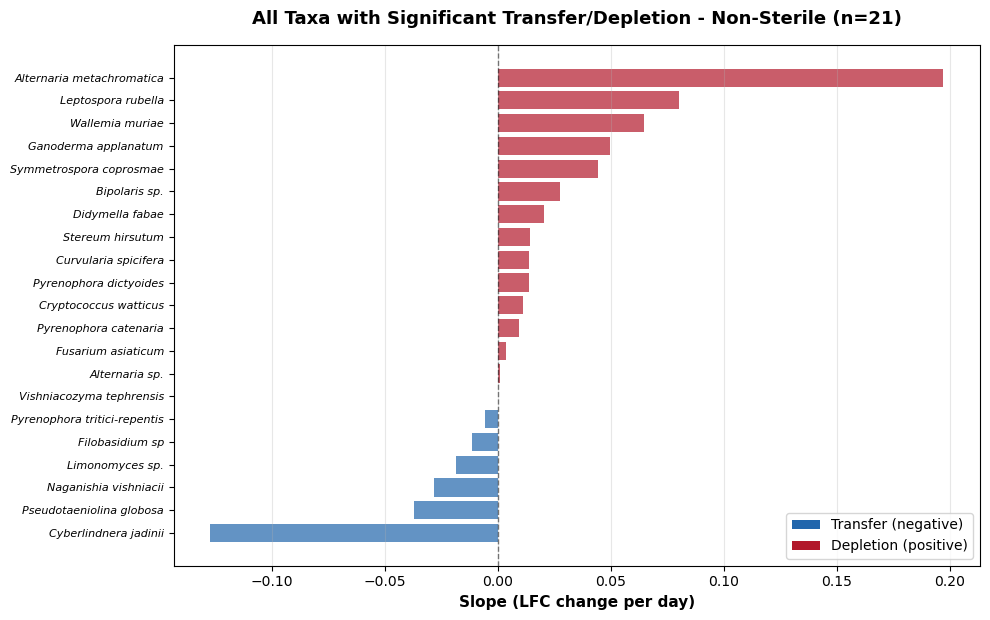

In [19]:
# === DATA PREPARATION ===
combined_non_sterile = pd.concat([
    df[df['q_val'] < 0.05].assign(day=day) 
    for day, df in results_species_level_non_sterile.items()
])
species_counts = combined_non_sterile['id'].value_counts()
multi_timepoint = combined_non_sterile[combined_non_sterile['id'].isin(
    species_counts[species_counts >= 2].index
)]

# === REGRESSION ANALYSIS ===
regression_results = []
for species, data in multi_timepoint.groupby('id'):
    slope, intercept, r_value, p_value, _ = stats.linregress(data['day'], data['lfc'])
    regression_results.append({
        'species': species,
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2,
        'p_value': p_value
    })

regression_df = pd.DataFrame(regression_results).sort_values('slope')
regression_df['pattern'] = regression_df.apply(
    lambda r: 'Transfer' if r['p_value'] < 0.05 and r['slope'] < 0 
    else 'Depletion' if r['p_value'] < 0.05 and r['slope'] > 0 
    else 'No change', axis=1
)

# Keep only taxa with significant directional changes
filtered_df = regression_df[regression_df['pattern'] != 'No change'].copy()

def extract_species_name(taxonomy):
    parts = taxonomy.split(';')
    genus = ''
    species = ''
    family = ''
    
    for part in parts:
        part = part.strip()
        if part.startswith('g__'):
            genus = part.replace('g__', '').strip()
        elif part.startswith('s__'):
            species_full = part.replace('s__', '').strip()
            if '_' in species_full:
                species = species_full.split('_')[1]
        elif part.startswith('f__'):
            family = part.replace('f__', '').strip()
    
    if genus and species:
        return f"{genus} {species}"
    elif genus:
        return f"{genus} sp."
    elif family:
        return family
    return parts[-1].strip()

filtered_df['species_name'] = filtered_df['species'].apply(extract_species_name)

# === REMOVE UNCLASSIFIED TAXA ===
# Remove taxa that are just underscores, empty, or contain only underscores/spaces
filtered_df = filtered_df[
    ~filtered_df['species_name'].str.replace('_', '').str.replace(' ', '').str.strip().isin(['', '__'])
].copy()

# Also remove if species_name is exactly '__' or just whitespace
filtered_df = filtered_df[
    (filtered_df['species_name'].str.strip() != '') & 
    (filtered_df['species_name'].str.strip() != '__') &
    (~filtered_df['species_name'].str.match(r'^_+$'))
].copy()

print(f"\nTotal taxa with significant directional changes: {len(filtered_df)}")
print(f"  • Transfer (negative slope): {(filtered_df['pattern'] == 'Transfer').sum()}")
print(f"  • Depletion (positive slope): {(filtered_df['pattern'] == 'Depletion').sum()}")

# === BAR CHART - ALL TAXA ===
fig, ax = plt.subplots(figsize=(10, max(6, len(filtered_df) * 0.3)))
colors = ['#2166ac' if p == 'Transfer' else '#b2182b' for p in filtered_df['pattern']]
y_pos = np.arange(len(filtered_df))

ax.barh(y_pos, filtered_df['slope'], color=colors, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(filtered_df['species_name'], style='italic', fontsize=8)
ax.set_xlabel('Slope (LFC change per day)', fontsize=11, fontweight='bold')
ax.set_title(f'All Taxa with Significant Transfer/Depletion - Non-Sterile (n={len(filtered_df)})', 
             fontsize=13, fontweight='bold', pad=15)
ax.axvline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
ax.grid(axis='x', alpha=0.3)

from matplotlib.patches import Patch
ax.legend([Patch(facecolor='#2166ac'), Patch(facecolor='#b2182b')], 
          ['Transfer (negative)', 'Depletion (positive)'], loc='lower right')

plt.tight_layout()
plt.show()


Filtered to 23 species with significant directional changes
  - Transfer (negative slope): 7
  - Depletion (positive slope): 16


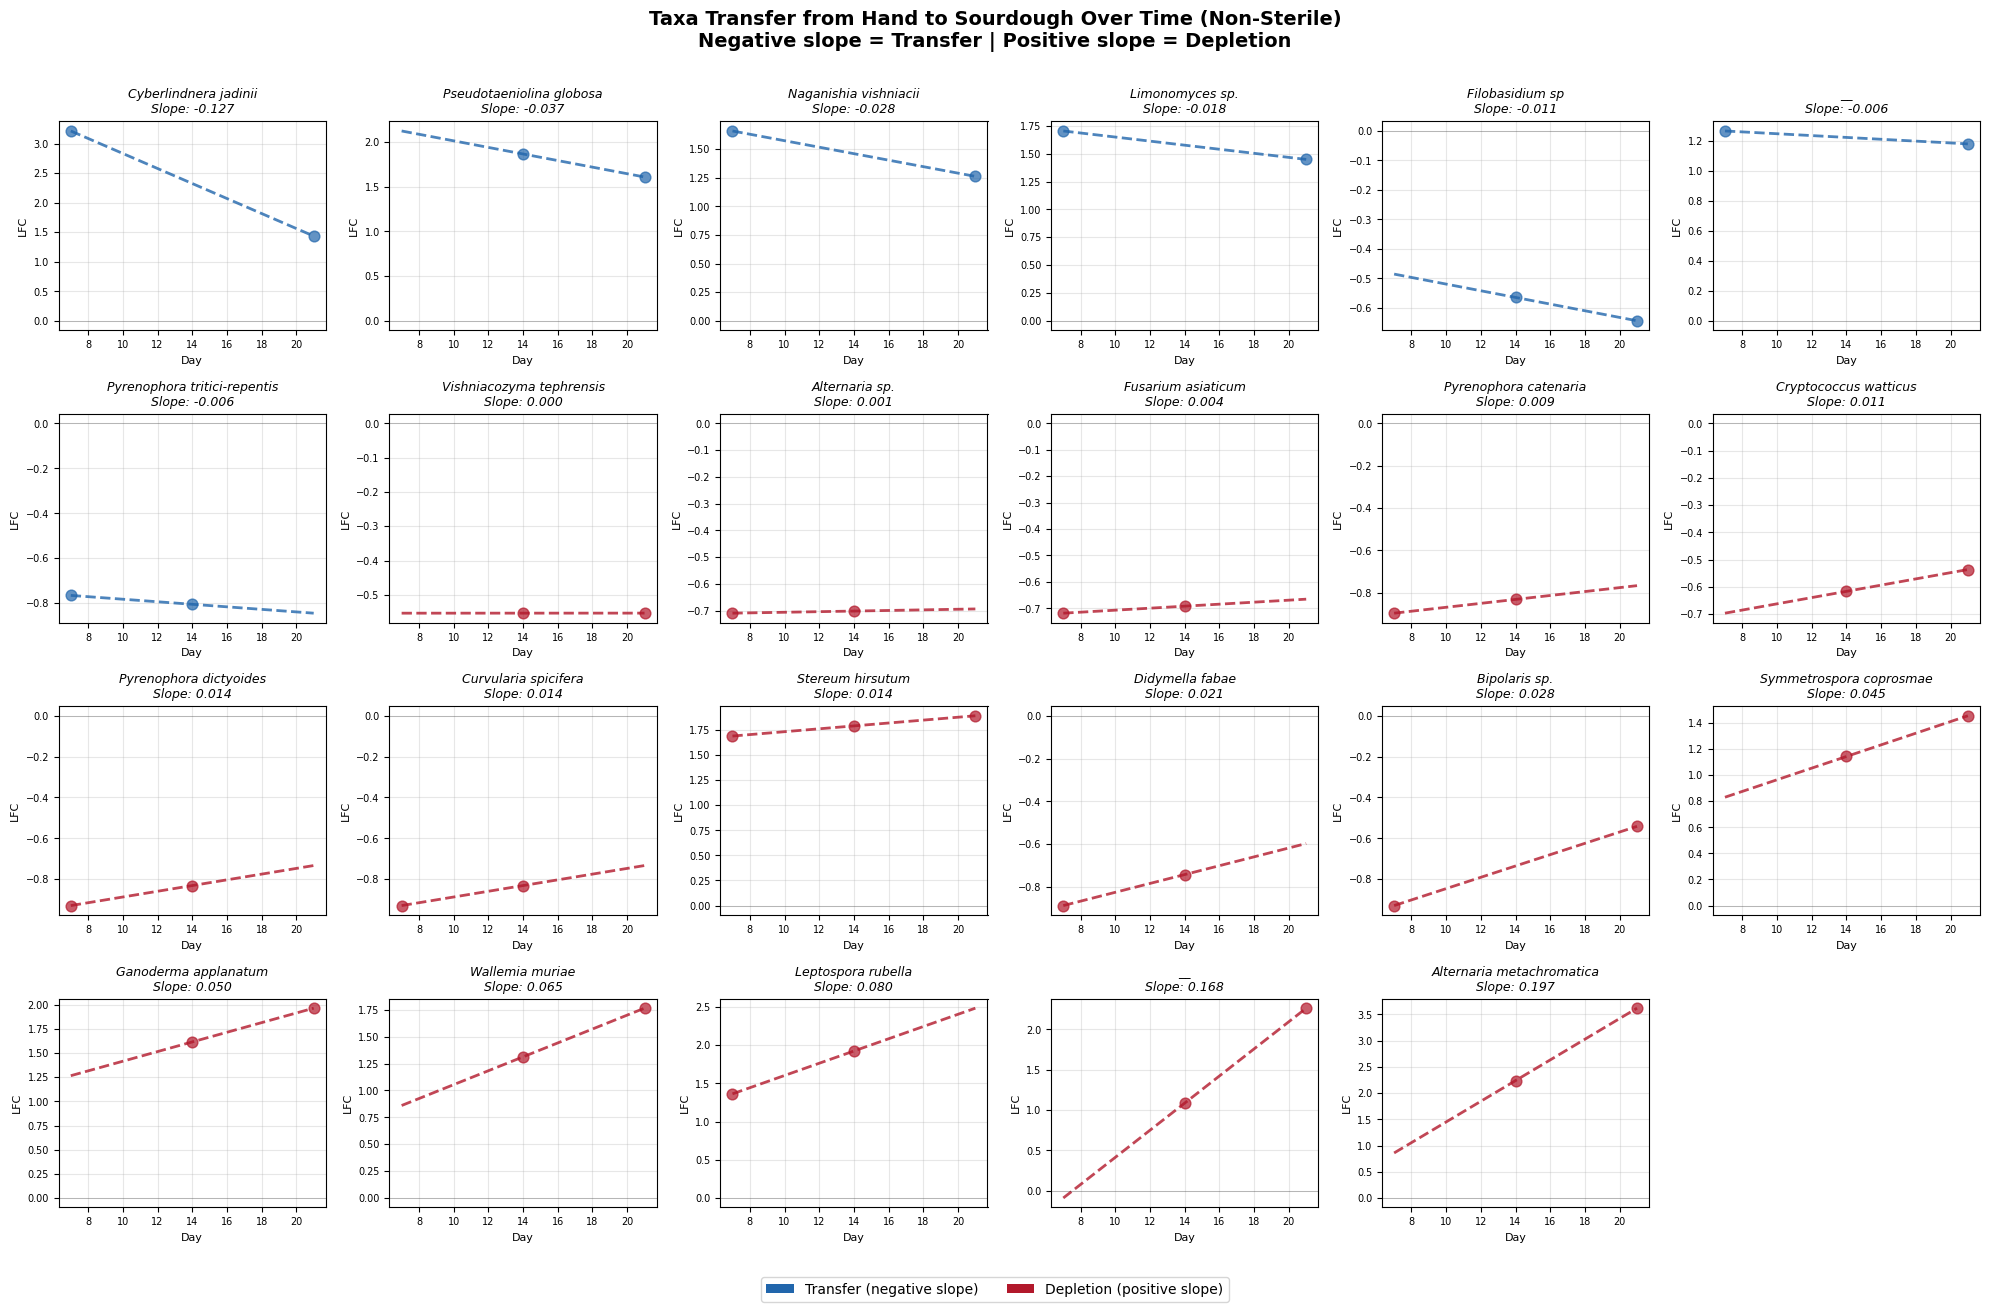


=== TRANSFER ANALYSIS SUMMARY (ALL SPECIES) ===

transfer_pattern
No change (non-significant)    46
Depletion (positive slope)     16
Transfer (negative slope)       7
Name: count, dtype: int64

=== TOP TRANSFERRING TAXA (Most negative slopes) ===
                                              species     slope  r_squared  \
34  k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S... -0.127147        1.0   
7   k__Fungi;p__Ascomycota;c__Dothideomycetes;o__M... -0.036816        1.0   
62  k__Fungi;p__Basidiomycota;c__Tremellomycetes;o... -0.028355        1.0   
42  k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_... -0.018244        1.0   
61  k__Fungi;p__Basidiomycota;c__Tremellomycetes;o... -0.011314        1.0   
29  k__Fungi;p__Ascomycota;c__Leotiomycetes;o__Hel... -0.006145        1.0   
26  k__Fungi;p__Ascomycota;c__Dothideomycetes;o__P... -0.005647        1.0   

    p_value  
34      0.0  
7       0.0  
62      0.0  
42      0.0  
61      0.0  
29      0.0  
26      0.0  

=== RESISTANT

In [21]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Prepare data for regression analysis
# Combine all days and filter for significant species
all_species_non_sterile = []
for day, df in results_species_level_non_sterile.items():
    df_sig = df[df['q_val'] < 0.05].copy()
    df_sig['day'] = day
    all_species_non_sterile.append(df_sig)

combined_non_sterile = pd.concat(all_species_non_sterile)

# Get species present at multiple timepoints (need at least 2 points for regression)
species_counts = combined_non_sterile.groupby('id').size()
multi_timepoint_species = species_counts[species_counts >= 2].index

# Step 2: Calculate regression slopes for all species at multiple timepoints
regression_results = []

for species in multi_timepoint_species:
    species_data = combined_non_sterile[combined_non_sterile['id'] == species]
    
    if len(species_data) >= 2:  # Need at least 2 points
        x = species_data['day'].values
        y = species_data['lfc'].values
        
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        
        regression_results.append({
            'species': species,
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_value**2,
            'p_value': p_value
        })

regression_df = pd.DataFrame(regression_results)

# Classify transfer patterns
def classify_transfer(slope, p_value, threshold=0.05):
    if p_value > threshold:
        return 'No change (non-significant)'
    elif slope < 0:  # Any negative slope = transfer
        return 'Transfer (negative slope)'
    elif slope > 0:  # Any positive slope = depletion
        return 'Depletion (positive slope)'
    else:
        return 'Stable (slope ≈ 0)'

regression_df['transfer_pattern'] = regression_df.apply(
    lambda row: classify_transfer(row['slope'], row['p_value']), axis=1
)

# Sort by slope (most negative = strongest transfer)
regression_df = regression_df.sort_values('slope')

# FILTER: Only keep species with negative or positive slopes (exclude stable and non-significant)
filtered_df = regression_df[regression_df['transfer_pattern'].isin([
    'Transfer (negative slope)', 
    'Depletion (positive slope)'
])].copy()

print(f"\nFiltered to {len(filtered_df)} species with significant directional changes")
print(f"  - Transfer (negative slope): {sum(filtered_df['transfer_pattern'] == 'Transfer (negative slope)')}")
print(f"  - Depletion (positive slope): {sum(filtered_df['transfer_pattern'] == 'Depletion (positive slope)')}")

# Step 3: Create visualization - Line plot with regression lines
def extract_genus_species(full_taxonomy):
    """Extract genus and species from full taxonomy string"""
    parts = full_taxonomy.split(';')
    genus = ''
    species = ''
    family = ''
    
    for part in parts:
        part = part.strip()
        if part.startswith('f__'):
            family = part.replace('f__', '').strip()
        elif part.startswith('g__'):
            genus = part.replace('g__', '').strip()
        elif part.startswith('s__'):
            species_full = part.replace('s__', '').strip()
            species_parts = species_full.split('_')
            if len(species_parts) >= 2:
                species = species_parts[1]
            else:
                species = species_full
    
    if genus and species:
        return f"{genus} {species}"
    elif genus:
        return f"{genus} sp."
    elif family:
        return family
    else:
        return full_taxonomy.split(';')[-1].strip()

# Determine grid size based on filtered species count
n_species = min(len(filtered_df), 30)
n_cols = 6
n_rows = int(np.ceil(n_species / n_cols))

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3.2))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

# Color map for transfer patterns
color_map = {
    'Transfer (negative slope)': '#2166ac',  # Blue
    'Depletion (positive slope)': '#b2182b',  # Red
}

for idx, species in enumerate(filtered_df['species'].head(30)):
    ax = axes[idx]
    
    # Get data for this species
    species_data = combined_non_sterile[combined_non_sterile['id'] == species].sort_values('day')
    
    # Get regression info
    reg_info = filtered_df[filtered_df['species'] == species].iloc[0]
    
    # Plot points
    ax.scatter(species_data['day'], species_data['lfc'], 
               color=color_map[reg_info['transfer_pattern']], s=60, alpha=0.7, zorder=3)
    
    # Plot regression line
    x_line = np.array([min(days), max(days)])
    y_line = reg_info['slope'] * x_line + reg_info['intercept']
    ax.plot(x_line, y_line, '--', 
            color=color_map[reg_info['transfer_pattern']], linewidth=2, alpha=0.8)
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Labels
    species_name = extract_genus_species(species)
    ax.set_title(f'{species_name}\nSlope: {reg_info["slope"]:.3f}', 
                 fontsize=9, fontstyle='italic')
    ax.set_xlabel('Day', fontsize=8)
    ax.set_ylabel('LFC', fontsize=8)
    ax.tick_params(labelsize=7)
    ax.grid(True, alpha=0.3)

# Remove empty subplots
for idx in range(n_species, len(axes)):
    fig.delaxes(axes[idx])

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=pattern) 
                   for pattern, color in color_map.items()]
fig.legend(handles=legend_elements, loc='lower center', ncol=2, 
           bbox_to_anchor=(0.5, -0.02), fontsize=10)

plt.suptitle('Taxa Transfer from Hand to Sourdough Over Time (Non-Sterile)\n' +
             'Negative slope = Transfer | Positive slope = Depletion',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0.02, 1, 0.99])
plt.show()

# Step 4: Summary statistics
print("\n=== TRANSFER ANALYSIS SUMMARY (ALL SPECIES) ===\n")
print(regression_df['transfer_pattern'].value_counts())
print("\n=== TOP TRANSFERRING TAXA (Most negative slopes) ===")
print(regression_df[regression_df['transfer_pattern'] == 'Transfer (negative slope)'].head(10)[
    ['species', 'slope', 'r_squared', 'p_value']
])

print("\n=== RESISTANT TAXA (Positive slopes or stable) ===")
resistant = regression_df[regression_df['transfer_pattern'].isin(['Depletion (positive slope)', 'Stable (slope ≈ 0)'])]
print(resistant.head(10)[['species', 'slope', 'r_squared', 'p_value']])
